In [1]:
%load_ext autoreload
%autoreload 2

## Making plots for potential prognostic predictability

In [2]:
import xarray as xr
import numpy as np
import gfdl_utils as gu
import glob
from dask.diagnostics import ProgressBar
from information import *
from processing import *
from variance import *
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

### Time horizon, global map

In [3]:
frequency = 'monthly'
smooth = 12

In [4]:
savedir = ppeDict['datasavedir']+'/processed/ppp_timehorizon/'
ds = xr.open_mfdataset(savedir+'*.'+frequency+'.smooth_'+str(smooth)+'.nc')
grid = xr.open_dataset(ppeDict['griddirtmp']+ppeDict['gridfile'])

In [5]:
landmask = generate_masks(grid)['global']

In [6]:
def draw_globalmap(da,grid,save=False,addname=None):
    crsP = ccrs.Robinson(central_longitude=-90)
    crsT = ccrs.PlateCarree()

    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})

    X = grid['geolon']
    Y = grid['geolat']
    Z = da.where(landmask)

    im = ax.pcolormesh(X,Y,Z,transform=crsT)

    ax.gridlines(color='gray',linestyle='dashed')
    ax.add_feature(cfeature.LAND,color='lightgrey')
    ax.set_title(da.name,fontsize=14)

    # Finally, add a colorbar
    cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.03,pad=0.05)
    cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)
    
    fig.tight_layout()
    
    if save:
        savedir = ppeDict['figsavedir']+'/ppp_timehorizon/'
        savenames = ['ppp_timehorizon',da.name,frequency,'smooth_'+str(smooth)]
        if addname is not None:
            savenames.append(addname)
        filename = '.'.join(savenames)
        fig.savefig(savedir+filename+'.png',transparent=True,dpi=300,bbox_inches='tight')
        

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-p

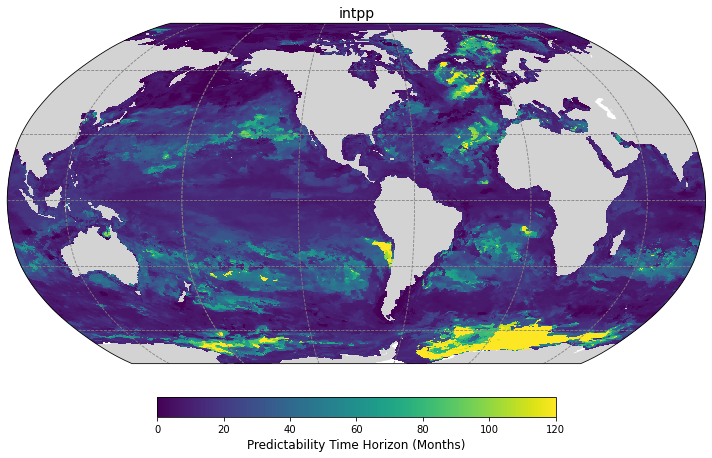

In [7]:
variable = 'intpp'
draw_globalmap(ds[variable],grid,save=True)

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-p

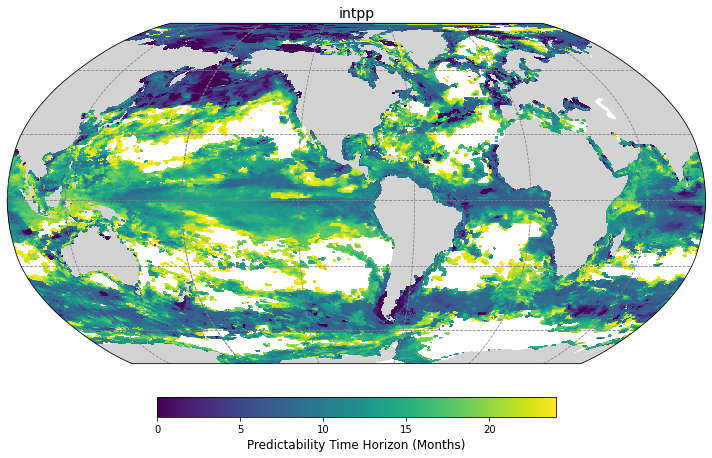

In [8]:
da = ds[variable].where(ds[variable]<=24)
draw_globalmap(da,grid,save=True,addname='under24mo')

### Regional means : compare variables

In [9]:
def draw_regionalmeans(ds):
    threshold = 0.235559205
    fig,ax=plt.subplots(figsize=(12,4))
    for name,da in ds.items():
        ax.plot(da['time']+1,da,label=name)
    ax.legend(frameon=False)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Potential Prognostic Predictability')
    ax.set_xlim([0,da['time'].max()])
    ax.set_ylim([0,1])
    ax.axhline(threshold,linestyle='--',color='gray')
    return ax

In [10]:
savedir = ppeDict['datasavedir']+'/processed/ppp_regionalmeans/'
maskname = 'pacific_T'
filename = '.'.join(['*',frequency,maskname,'nc'])
ds = xr.open_mfdataset(savedir+filename)

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

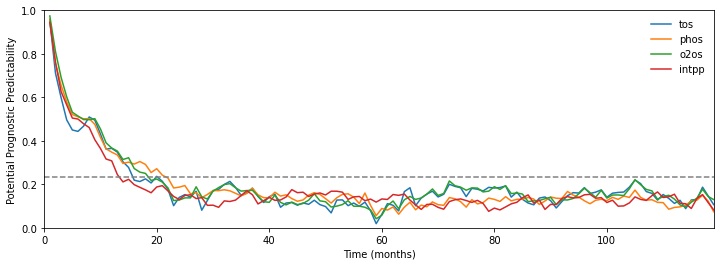

In [11]:
variables = ['tos','phos','o2os','intpp']
draw_regionalmeans(ds[variables])

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

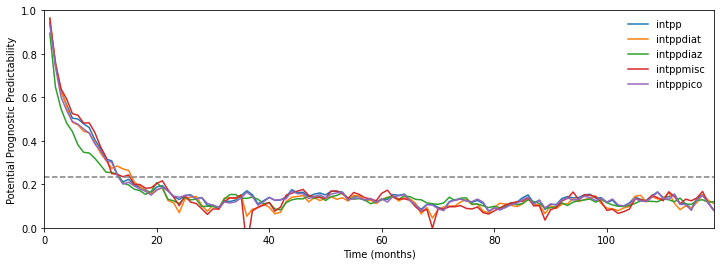

In [12]:
variables = ['intpp','intppdiat','intppdiaz','intppmisc','intpppico']
draw_regionalmeans(ds[variables])

### Regional means : compare regions

In [13]:
variable = 'intpp'

In [14]:
savedir = ppeDict['datasavedir']+'/processed/ppp_regionalmeans/'
filename = '.'.join([variable,frequency,'*','nc'])
def preprocess(ds):
    filename_components = os.path.basename(ds.encoding["source"]).split('.')
    variable = filename_components[0]
    maskname = filename_components[-2]
    return ds.rename({variable:maskname})
ds = xr.open_mfdataset(savedir+filename,preprocess=preprocess)

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

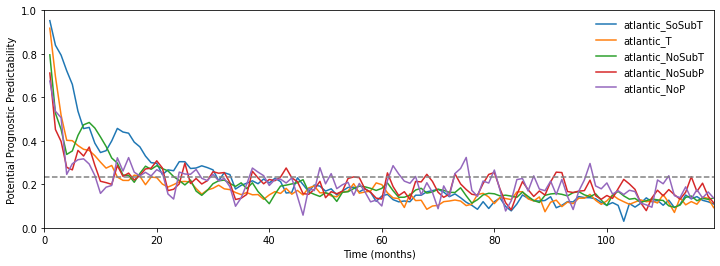

In [15]:
regions = ['atlantic_SoSubT','atlantic_T','atlantic_NoSubT','atlantic_NoSubP','atlantic_NoP']
draw_regionalmeans(ds[regions])

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

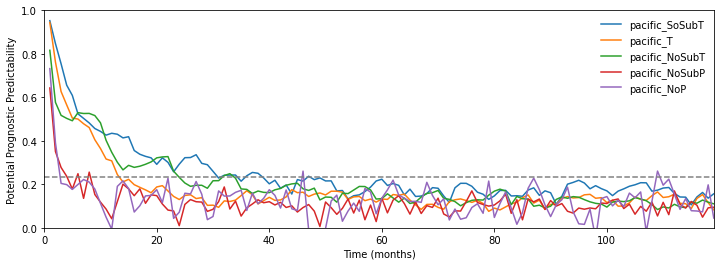

In [16]:
regions = ['pacific_SoSubT','pacific_T','pacific_NoSubT','pacific_NoSubP','pacific_NoP']
draw_regionalmeans(ds[regions])

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

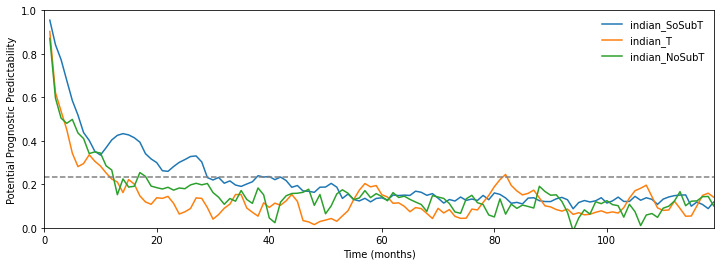

In [17]:
regions = ['indian_SoSubT','indian_T','indian_NoSubT']
draw_regionalmeans(ds[regions])

### Zonal means

In [18]:
savedir = ppeDict['datasavedir']+'/processed/ppp_zonalmeans/'
maskname = 'atlantic_global'
filename = '.'.join(['*',frequency,maskname,'nc'])
ds = xr.open_mfdataset(savedir+filename)

In [19]:
def draw_zonalmeans(da):
    fig,ax = plt.subplots(figsize=(6,8))
    im = ax.pcolormesh(da['time'],da['geolat_bin'],da.transpose(),shading='auto')
    im.set_clim([0,1])
    ax.set_xlim([0,36])
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Latitude ($^\circ N$)')
    ax.set_title(da.name,fontsize=14)
    cb = fig.colorbar(im,ax=ax,orientation='vertical',pad=0.05,fraction=0.04)
    cb.set_label('Potential Prognostic Predictability',fontsize=14)

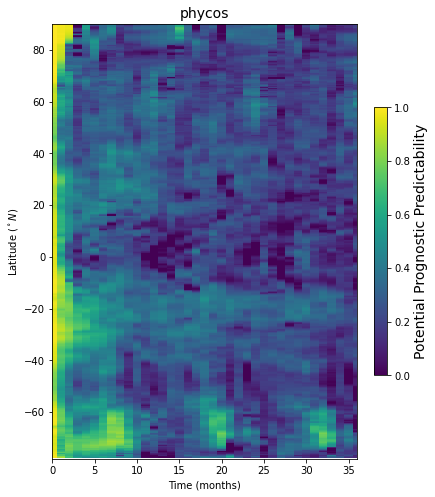

In [20]:
variable = 'phycos'
da = ds[variable]
draw_zonalmeans(da)

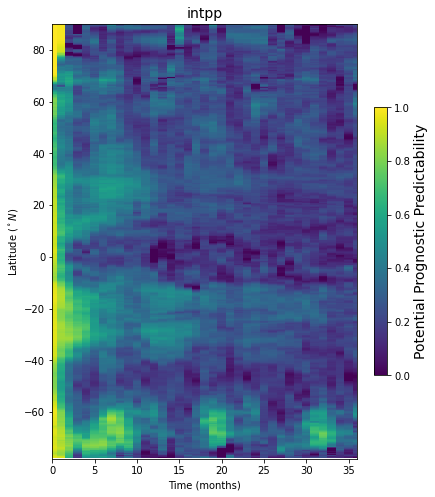

In [21]:
variable = 'intpp'
da = ds[variable]
draw_zonalmeans(da)

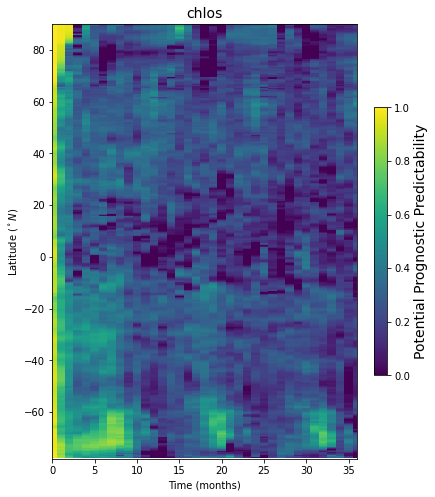

In [22]:
variable = 'chlos'
da = ds[variable]
draw_zonalmeans(da)